# Multi-Source Fundamentals: Sharadar + Custom LSEG

**Working Example**: Using actual LSEG database columns with automatic SID translation

This notebook demonstrates combining Sharadar SF1 with your custom LSEG data using available metrics:
- **Sharadar**: ROE, P/E Ratio, D/E Ratio  
- **LSEG**: ROE (ReturnOnEquity_SmartEstimat), PEG Ratio, Market Cap

**What This Shows:**
1. Load and compare metrics from both sources
2. Build a consensus score when both sources agree on quality
3. Run a working backtest using both datasets with **automatic SID translation**

**NEW**: The CustomSQLiteLoader now automatically translates between simulation SIDs and bundle SIDs, so custom databases can use bundle SIDs while `run_algorithm()` uses different internal SIDs.

**Test Universe**: Stocks from your LSEG database (AAPL, MSFT, GOOGL, etc.)

## Setup

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Add custom_data to path
sys.path.insert(0, '/app/examples/custom_data')

from zipline import run_algorithm
from zipline.api import (
    attach_pipeline,
    pipeline_output,
    order_target_percent,
    record,
    schedule_function,
    date_rules,
    time_rules,
)
from zipline.pipeline import Pipeline
from zipline.pipeline.data.sharadar import SharadarFundamentals
from zipline.pipeline.filters import StaticAssets
from zipline.data.bundles import load as load_bundle, register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle
from zipline.data.custom import CustomSQLiteLoader
from zipline.pipeline.data.db import Database, Column

# Pyfolio imports
try:
    import pyfolio as pf
    PYFOLIO_AVAILABLE = True
    print("✓ Pyfolio available")
except ImportError:
    PYFOLIO_AVAILABLE = False
    print("⚠ Pyfolio not available - install with: pip install pyfolio-reloaded")

# Register bundle
register('sharadar', sharadar_bundle())

# Set plot style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Imports complete")

✓ Pyfolio available
✓ Imports complete


## Define Custom Fundamentals Database

In [2]:
class CustomFundamentals(Database):
    """Custom LSEG fundamentals - using actual column names from your database."""
    CODE = "fundamentals"
    LOOKBACK_WINDOW = 240
    
    # Metrics available in your LSEG database
    ReturnOnEquity_SmartEstimat = Column(float)  # ROE equivalent
    ForwardPEG_DailyTimeSeriesRatio_ = Column(float)  # PEG ratio (P/E to Growth)
    Debt_Total = Column(float)  # Total debt
    CompanyMarketCap = Column(float)  # Market cap
    EarningsPerShare_Actual = Column(float)  # EPS
    
print("✓ Custom database defined")

✓ Custom database defined


## Setup Custom Loader (Required for Backtest)

In [3]:
def setup_multi_source_loader():
    """Setup loader that handles BOTH Sharadar and Custom LSEG data with SID translation."""
    from zipline.pipeline.loaders.sharadar_fundamentals import make_sharadar_fundamentals_loader

    # Load bundle to get asset_finder for SID translation
    bundle_data = load_bundle('sharadar')
    asset_finder = bundle_data.asset_finder

    class MultiSourceLoaderDict(dict):
        def __init__(self, sharadar_loader, custom_loader):
            super().__init__()
            self.sharadar_loader = sharadar_loader
            self.custom_loader = custom_loader

        def get(self, key, default=None):
            # Check if it's a BoundColumn
            if hasattr(key, 'dataset'):
                # Get the dataset name from the dataset object
                # The dataset has __name__ attribute OR we can use str() representation
                if hasattr(key.dataset, '__name__'):
                    dataset_name = key.dataset.__name__
                else:
                    # Parse from string representation: "<DataSet: 'SharadarFundamentals', ...>"
                    dataset_str = str(key.dataset)
                    if "'" in dataset_str:
                        dataset_name = dataset_str.split("'")[1]
                    else:
                        dataset_name = dataset_str

                # Route based on dataset name
                if 'Sharadar' in dataset_name:
                    return self.sharadar_loader
                elif 'Custom' in dataset_name:
                    # For custom columns, check if registered
                    if key in self:
                        return self[key]
                    # Try matching by column name
                    for registered_col, loader in self.items():
                        if hasattr(registered_col, 'name') and registered_col.name == key.name:
                            return loader

            raise KeyError(f"No loader for {key}")

    # Create Sharadar loader
    sharadar_loader = make_sharadar_fundamentals_loader('sharadar')

    # Create custom LSEG loader WITH SID TRANSLATION
    # Pass asset_finder to enable automatic SID translation between
    # simulation SIDs (from run_algorithm) and bundle SIDs (in database)
    db_dir = Path.home() / '.zipline' / 'data' / 'custom'
    custom_sqlite_loader = CustomSQLiteLoader(
        "fundamentals",
        db_dir=db_dir,
        asset_finder=asset_finder  # KEY: Enable SID translation
    )

    # Create multi-source loader
    multi_loader = MultiSourceLoaderDict(sharadar_loader, custom_sqlite_loader)

    # Register custom columns
    for attr_name in dir(CustomFundamentals):
        attr = getattr(CustomFundamentals, attr_name)
        if hasattr(attr, 'dataset'):
            multi_loader[attr] = custom_sqlite_loader

    print(f"✓ Multi-source loader ready (with SID translation)")
    print(f"  - Sharadar: {sharadar_loader.fundamentals_path}")
    print(f"  - Custom LSEG: {db_dir / 'fundamentals.sqlite'}")
    print(f"  - Custom columns registered: {len(multi_loader)}")
    print(f"  - SID translation: ENABLED")

    return multi_loader

custom_loader = setup_multi_source_loader()

✓ Multi-source loader ready (with SID translation)
  - Sharadar: /root/.zipline/data/sharadar/2025-11-17T08;19;43.398169/fundamentals/sf1.h5
  - Custom LSEG: /root/.zipline/data/custom/fundamentals.sqlite
  - Custom columns registered: 5
  - SID translation: ENABLED


## Define Multi-Source Strategy

In [4]:
# Strategy configuration
TOP_N_STOCKS = 5
UNIVERSE_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'JPM', 'V', 'WMT', 'XOM', 'TSLA']

def make_pipeline():
    """Pipeline using both Sharadar and Custom LSEG data."""
    
    # Load universe from bundle
    bundle_data = load_bundle('sharadar')
    
    # Get assets for our tickers
    assets = []
    for ticker in UNIVERSE_TICKERS:
        try:
            asset = bundle_data.asset_finder.lookup_symbol(ticker, as_of_date=None)
            assets.append(asset)
        except:
            pass
    
    universe = StaticAssets(assets)
    
    # Sharadar metrics
    s_roe = SharadarFundamentals.roe.latest
    s_pe = SharadarFundamentals.pe.latest
    s_de = SharadarFundamentals.de.latest
    
    # Custom LSEG metrics (using actual column names)
    l_roe = CustomFundamentals.ReturnOnEquity_SmartEstimat.latest
    l_peg = CustomFundamentals.ForwardPEG_DailyTimeSeriesRatio_.latest
    l_marketcap = CustomFundamentals.CompanyMarketCap.latest
    
    return Pipeline(
        columns={
            's_roe': s_roe,
            's_pe': s_pe,
            's_de': s_de,
            'l_roe': l_roe,
            'l_peg': l_peg,
            'l_marketcap': l_marketcap,
        },
        screen=universe,
    )

print("✓ Pipeline factory defined")

✓ Pipeline factory defined


## Strategy Logic

In [5]:
def initialize(context):
    """Initialize multi-source strategy."""
    attach_pipeline(make_pipeline(), 'multi_source')
    
    schedule_function(
        rebalance,
        date_rules.month_start(),
        time_rules.market_open(hours=1)
    )
    
    context.stocks_held = []
    print("\n" + "="*80)
    print("Multi-Source Fundamentals Strategy")
    print("="*80)
    print(f"Universe: {len(UNIVERSE_TICKERS)} stocks")
    print(f"Sharadar: ROE, P/E, D/E")
    print(f"LSEG: ROE, PEG, MarketCap")
    print(f"Top N: {TOP_N_STOCKS}")
    print("="*80 + "\n")

def before_trading_start(context, data):
    context.pipeline_data = pipeline_output('multi_source')

def rebalance(context, data):
    """Monthly rebalancing with consensus scoring."""
    df = context.pipeline_data.copy()
    
    if len(df) == 0:
        return
    
    # Consensus scoring
    df['score'] = 0
    
    # Sharadar points
    df.loc[(df['s_roe'] > 0.15) & (df['s_roe'].notna()), 'score'] += 1
    df.loc[(df['s_pe'] < 25) & (df['s_pe'] > 0), 'score'] += 1
    df.loc[(df['s_de'] < 2) & (df['s_de'].notna()), 'score'] += 1
    
    # LSEG bonus (when both sources agree on quality)
    # Both sources show high ROE
    both_roe = (df['s_roe'].notna()) & (df['l_roe'].notna()) & (df['l_roe'] > 15.0)  # LSEG ROE is in percentage
    df.loc[both_roe, 'score'] += 2
    
    # LSEG PEG is reasonable (< 2.0 means stock isn't overvalued relative to growth)
    df.loc[(df['l_peg'] > 0) & (df['l_peg'] < 2.0), 'score'] += 1
    
    # Select top N by score
    ranked = df.sort_values('score', ascending=False)
    target_stocks = ranked.head(TOP_N_STOCKS).index.tolist()
    
    # Equal weight
    weight = 1.0 / len(target_stocks) if target_stocks else 0
    
    for stock in target_stocks:
        if data.can_trade(stock):
            order_target_percent(stock, weight)
    
    for stock in context.portfolio.positions:
        if stock not in target_stocks and data.can_trade(stock):
            order_target_percent(stock, 0)
    
    # Log
    lseg_confirmed = ranked.head(TOP_N_STOCKS)['l_roe'].notna().sum()
    print(f"[{context.datetime.date()}] {len(target_stocks)} stocks, {lseg_confirmed} with LSEG data")

def analyze(context, perf):
    """Analyze results with detailed metrics and pyfolio."""
    returns = perf['returns']
    
    # Calculate basic metrics
    total_return = (perf['portfolio_value'].iloc[-1] / perf['portfolio_value'].iloc[0] - 1) * 100
    
    # Annualized metrics
    days = (perf.index[-1] - perf.index[0]).days
    years = days / 365.25
    cagr = ((perf['portfolio_value'].iloc[-1] / perf['portfolio_value'].iloc[0]) ** (1/years) - 1) * 100
    
    # Risk metrics
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    sortino = returns.mean() / returns[returns < 0].std() * np.sqrt(252) if len(returns[returns < 0]) > 0 else 0
    
    # Drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min() * 100
    
    # Win rate
    winning_days = (returns > 0).sum()
    total_days = len(returns)
    win_rate = (winning_days / total_days * 100) if total_days > 0 else 0
    
    print("\n" + "="*80)
    print("BACKTEST RESULTS")
    print("="*80)
    print(f"\nPeriod: {perf.index[0].date()} to {perf.index[-1].date()} ({days} days)")
    print(f"\nReturns:")
    print(f"  Total Return:       {total_return:>10.2f}%")
    print(f"  CAGR:               {cagr:>10.2f}%")
    print(f"  Final Value:        ${perf['portfolio_value'].iloc[-1]:>10,.2f}")
    print(f"\nRisk Metrics:")
    print(f"  Sharpe Ratio:       {sharpe:>10.2f}")
    print(f"  Sortino Ratio:      {sortino:>10.2f}")
    print(f"  Max Drawdown:       {max_dd:>10.2f}%")
    print(f"  Volatility (ann):   {returns.std() * np.sqrt(252) * 100:>10.2f}%")
    print(f"\nTrading:")
    print(f"  Win Rate:           {win_rate:>10.2f}%")
    print(f"  Avg Daily Return:   {returns.mean() * 100:>10.4f}%")
    print(f"  Best Day:           {returns.max() * 100:>10.2f}%")
    print(f"  Worst Day:          {returns.min() * 100:>10.2f}%")
    print("="*80)
    
    return perf

print("✓ Strategy functions defined")

✓ Strategy functions defined


## Run Backtest

In [12]:
START = pd.Timestamp('2020-01-01')  # No timezone!
END = pd.Timestamp('2025-11-01')    # No timezone!

print(f"Running backtest: {START.date()} to {END.date()}\n")

try:
    results = run_algorithm(
        start=START,
        end=END,
        initialize=initialize,
        before_trading_start=before_trading_start,
        analyze=analyze,
        capital_base=100000,
        bundle='sharadar',
        custom_loader=custom_loader,  # KEY: Pass custom loader here
    )
    print("\n✓ Backtest successful!")
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()
    results = None

Running backtest: 2020-01-01 to 2025-11-01


Multi-Source Fundamentals Strategy
Universe: 11 stocks
Sharadar: ROE, P/E, D/E
LSEG: ROE, PEG, MarketCap
Top N: 5

[2020-01-02] 5 stocks, 4 with LSEG data
[2020-02-03] 5 stocks, 4 with LSEG data
[2020-03-02] 5 stocks, 5 with LSEG data
[2020-04-01] 5 stocks, 5 with LSEG data
[2020-05-01] 5 stocks, 4 with LSEG data
[2020-06-01] 5 stocks, 4 with LSEG data
[2020-07-01] 5 stocks, 4 with LSEG data
[2020-08-03] 5 stocks, 4 with LSEG data
[2020-09-01] 5 stocks, 4 with LSEG data
[2020-10-01] 5 stocks, 4 with LSEG data
[2020-11-02] 5 stocks, 4 with LSEG data
[2020-12-01] 5 stocks, 5 with LSEG data
[2021-01-04] 5 stocks, 5 with LSEG data
[2021-02-01] 5 stocks, 5 with LSEG data
[2021-03-01] 5 stocks, 4 with LSEG data
[2021-04-01] 5 stocks, 5 with LSEG data
[2021-05-03] 5 stocks, 5 with LSEG data
[2021-06-01] 5 stocks, 5 with LSEG data
[2021-07-01] 5 stocks, 5 with LSEG data
[2021-08-02] 5 stocks, 4 with LSEG data
[2021-09-01] 5 stocks, 5 with LSEG data


## Performance Analysis & Visualization

In [13]:
if results is not None:
    # Export full results to CSV
    output_file = '/notebooks/multi_source_backtest_results.csv'
    results.to_csv(output_file)
    print(f"✓ Results exported to: {output_file}")
    
    # Create summary statistics
    summary = {
        'Metric': [
            'Start Date',
            'End Date',
            'Total Days',
            'Initial Capital',
            'Final Value',
            'Total Return (%)',
            'CAGR (%)',
            'Sharpe Ratio',
            'Sortino Ratio',
            'Max Drawdown (%)',
            'Volatility (ann %)',
            'Win Rate (%)',
            'Best Day (%)',
            'Worst Day (%)',
            'Avg Daily Return (%)'
        ],
        'Value': [
            results.index[0].date(),
            results.index[-1].date(),
            (results.index[-1] - results.index[0]).days,
            results['portfolio_value'].iloc[0],
            results['portfolio_value'].iloc[-1],
            (results['portfolio_value'].iloc[-1] / results['portfolio_value'].iloc[0] - 1) * 100,
            ((results['portfolio_value'].iloc[-1] / results['portfolio_value'].iloc[0]) ** 
             (365.25 / (results.index[-1] - results.index[0]).days) - 1) * 100,
            results['returns'].mean() / results['returns'].std() * np.sqrt(252),
            results['returns'].mean() / results['returns'][results['returns'] < 0].std() * np.sqrt(252),
            ((1 + results['returns']).cumprod() / 
             (1 + results['returns']).cumprod().expanding().max() - 1).min() * 100,
            results['returns'].std() * np.sqrt(252) * 100,
            (results['returns'] > 0).sum() / len(results['returns']) * 100,
            results['returns'].max() * 100,
            results['returns'].min() * 100,
            results['returns'].mean() * 100
        ]
    }
    
    summary_df = pd.DataFrame(summary)
    summary_file = '/notebooks/multi_source_backtest_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    print(f"✓ Summary exported to: {summary_file}")
    
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("="*80)

✓ Results exported to: /notebooks/multi_source_backtest_results.csv
✓ Summary exported to: /notebooks/multi_source_backtest_summary.csv

SUMMARY STATISTICS
              Metric          Value
          Start Date     2020-01-02
            End Date     2025-10-31
          Total Days           2128
     Initial Capital       100000.0
         Final Value  577258.429696
    Total Return (%)      477.25843
            CAGR (%)      35.108174
        Sharpe Ratio       1.177284
       Sortino Ratio        1.56869
    Max Drawdown (%)     -41.099999
  Volatility (ann %)      29.230099
        Win Rate (%)      55.419223
        Best Day (%)      10.658374
       Worst Day (%)     -12.714895
Avg Daily Return (%)       0.136556


## Export Results

Generating Pyfolio tearsheet...


/usr/local/lib/python3.11/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '35.141%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2020-01-02
End date,2025-10-31
Total months,69
,Backtest
Annual return,35.141%
Cumulative returns,477.258%
Annual volatility,29.23%
Sharpe ratio,1.18
Calmar ratio,0.86
Stability,0.87
Max drawdown,-41.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.10,2022-01-03,2022-12-28,2023-07-13,398
1,35.31,2020-02-19,2020-03-23,2020-07-02,96
2,22.10,2025-02-14,2025-04-08,2025-06-16,86
3,16.37,2020-08-31,2020-09-23,2020-11-24,62
4,11.49,2024-07-10,2024-08-05,2024-09-19,52


/usr/local/lib/python3.11/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.14%,-12.71%,10.66%



✓ Pyfolio analysis complete


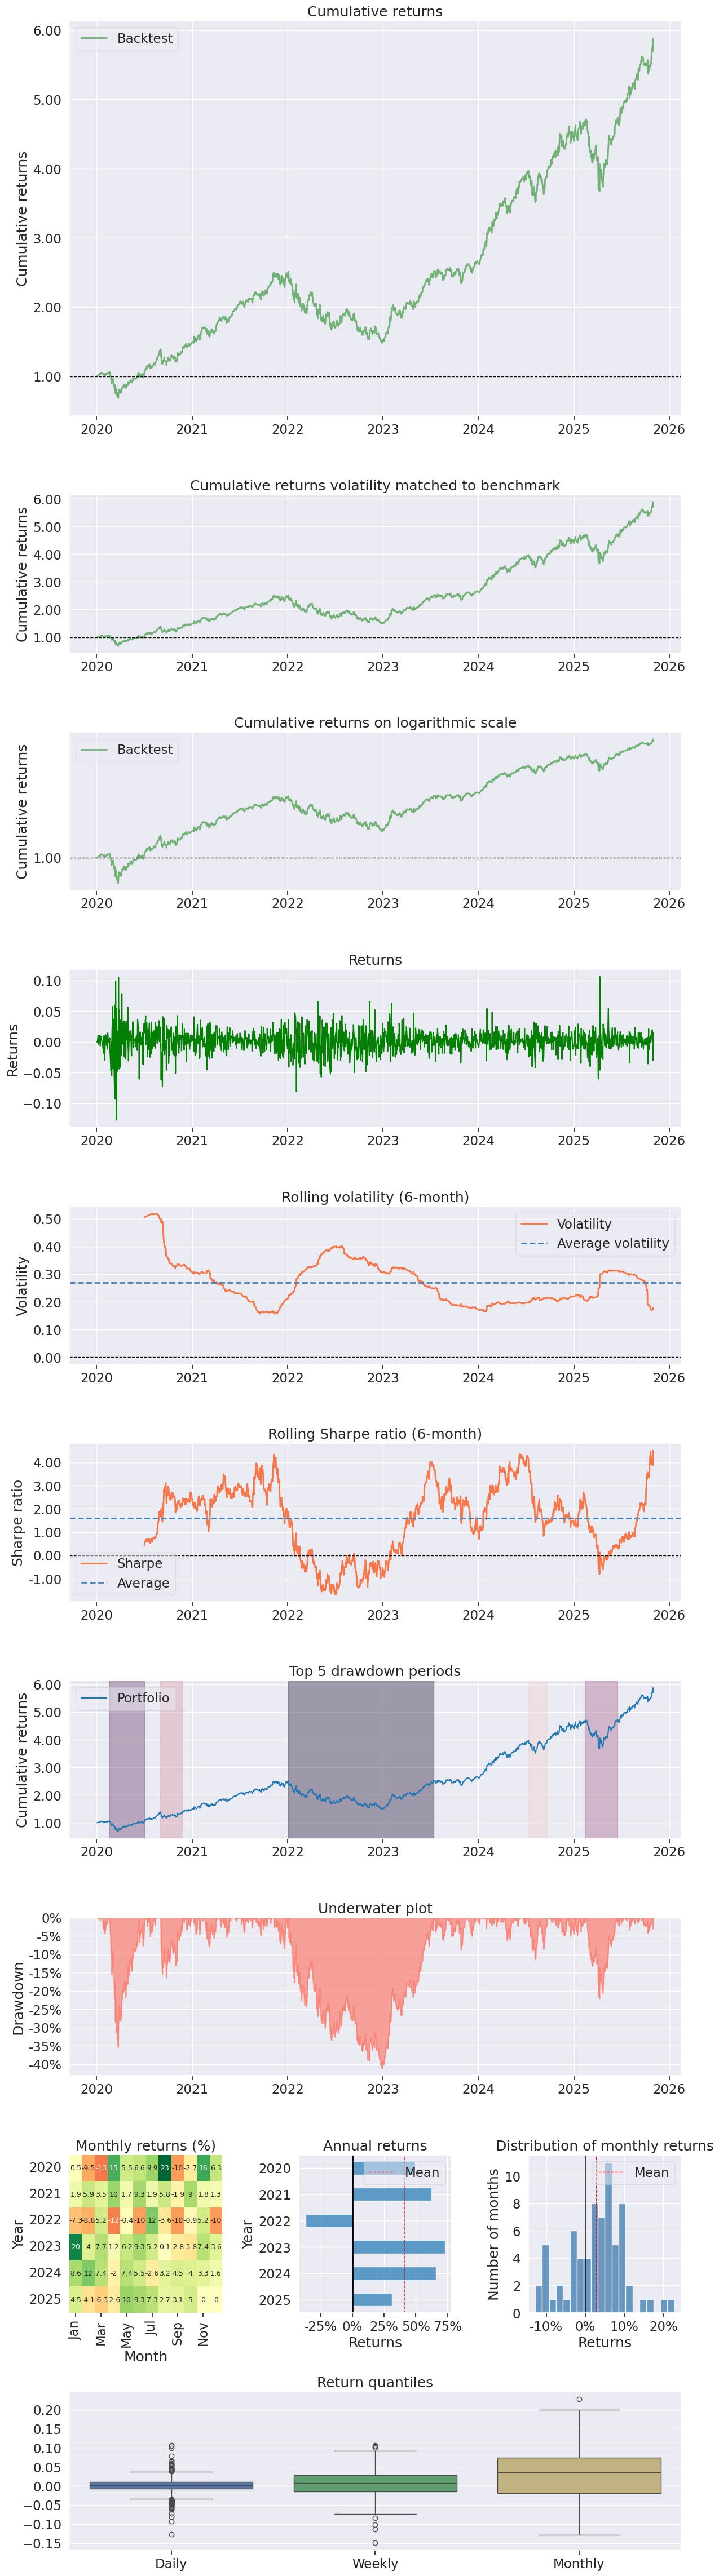

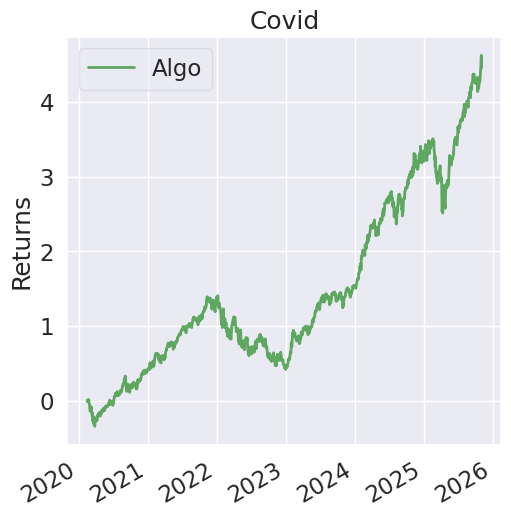

In [14]:
if results is not None and PYFOLIO_AVAILABLE:
    print("Generating Pyfolio tearsheet...")
    print("="*80)
    
    # Extract returns and positions for pyfolio
    returns = results['returns']
    positions = None  # Pyfolio can work without positions
    transactions = None  # Pyfolio can work without transactions
    
    try:
        # Create a simple tearsheet
        pf.create_full_tear_sheet(returns, benchmark_rets=None)
        print("\n✓ Pyfolio analysis complete")
    except Exception as e:
        print(f"⚠ Pyfolio tearsheet generation failed: {e}")
        print("Note: This is optional - basic analysis is shown above")
        
elif results is not None and not PYFOLIO_AVAILABLE:
    print("="*80)
    print("Pyfolio not available")
    print("="*80)
    print("\nTo install pyfolio-reloaded:")
    print("  pip install pyfolio-reloaded")
    print("\nThis will enable additional tearsheet analysis including:")
    print("  - Rolling statistics")
    print("  - Exposure analysis")  
    print("  - Position concentration")
    print("  - Transaction analysis")
    print("="*80)

## Pyfolio Tearsheet (if available)

/tmp/ipykernel_22/2236970625.py:49: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_returns.index = monthly_returns.index.to_period('M')


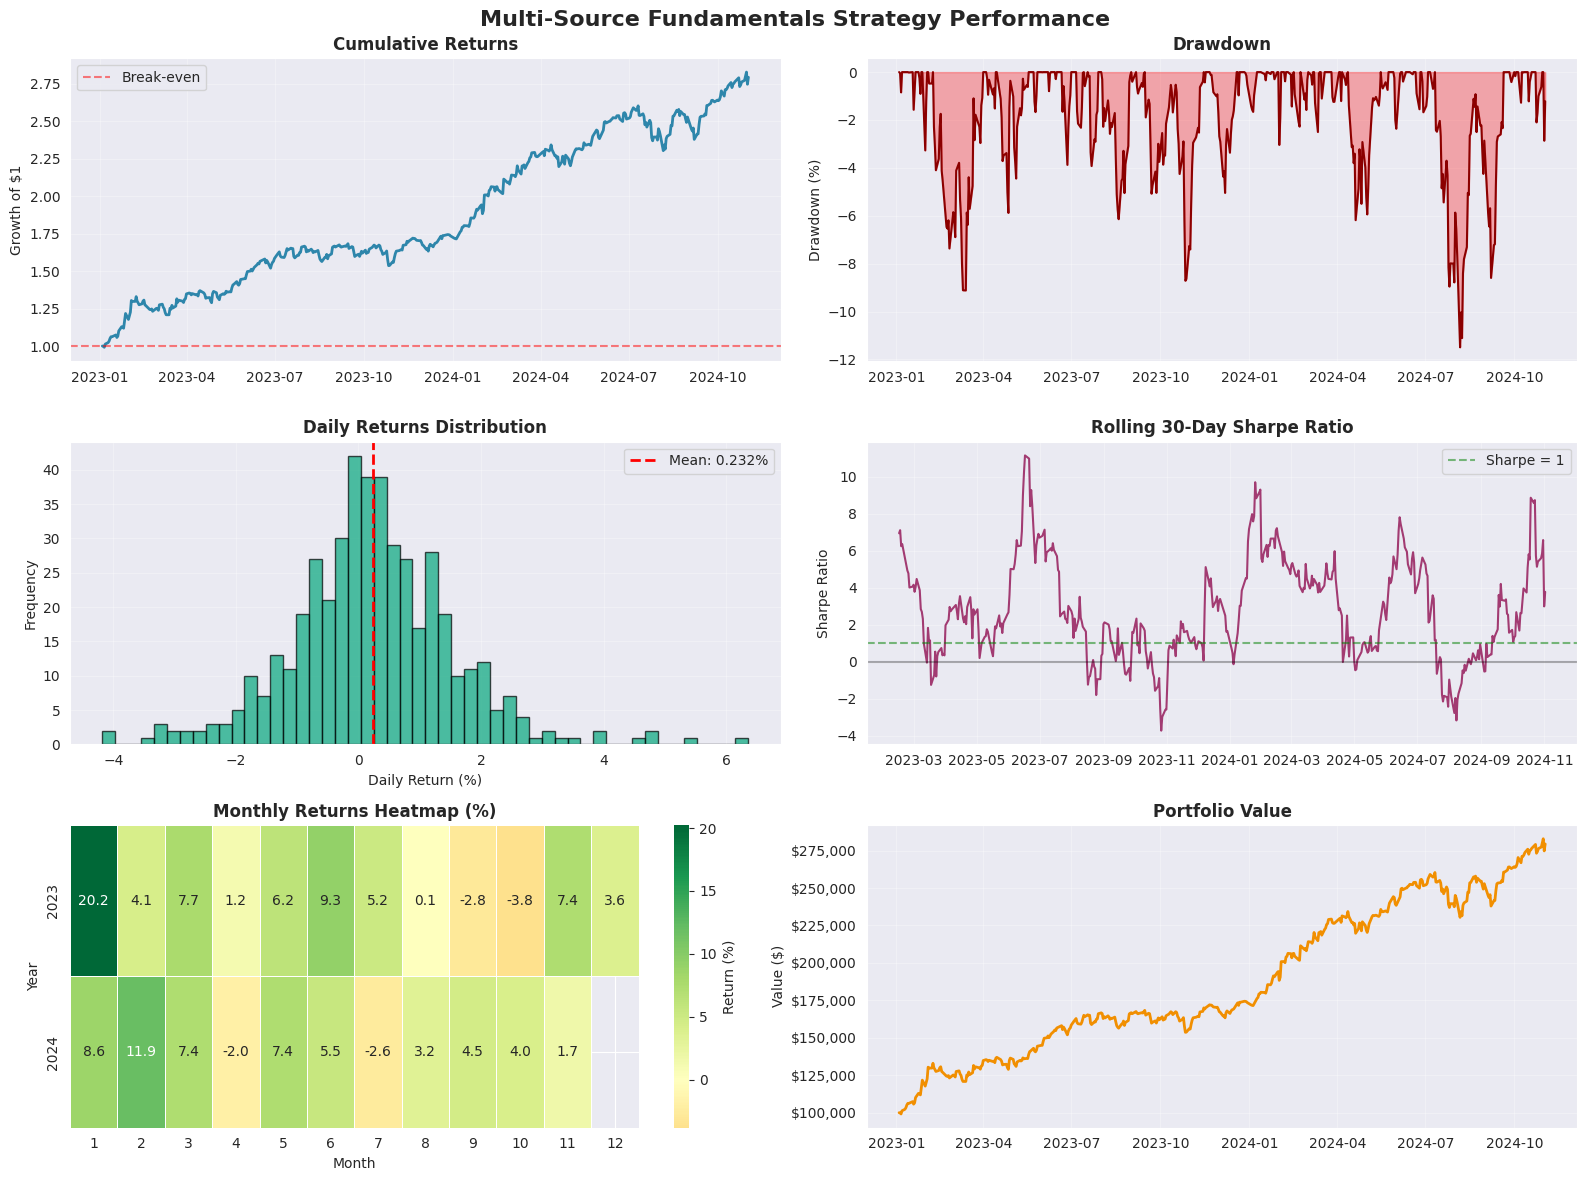


✓ Visualizations complete


In [9]:
if results is not None:
    # Extract returns and positions
    returns = results['returns']
    positions = results[[col for col in results.columns if 'positions' in col.lower()]]
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Multi-Source Fundamentals Strategy Performance', fontsize=16, fontweight='bold')
    
    # 1. Cumulative Returns
    cumulative = (1 + returns).cumprod()
    axes[0, 0].plot(cumulative.index, cumulative.values, linewidth=2, color='#2E86AB')
    axes[0, 0].set_title('Cumulative Returns', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Growth of $1')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Break-even')
    axes[0, 0].legend()
    
    # 2. Drawdown
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max * 100
    axes[0, 1].fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
    axes[0, 1].plot(drawdown.index, drawdown.values, linewidth=1.5, color='darkred')
    axes[0, 1].set_title('Drawdown', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Drawdown (%)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Daily Returns Distribution
    axes[1, 0].hist(returns * 100, bins=50, alpha=0.7, color='#06A77D', edgecolor='black')
    axes[1, 0].axvline(returns.mean() * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {returns.mean()*100:.3f}%')
    axes[1, 0].set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Daily Return (%)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Rolling Sharpe (30-day)
    rolling_sharpe = returns.rolling(30).mean() / returns.rolling(30).std() * np.sqrt(252)
    axes[1, 1].plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=1.5, color='#A23B72')
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 1].axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
    axes[1, 1].set_title('Rolling 30-Day Sharpe Ratio', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Monthly Returns Heatmap
    monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100
    monthly_returns.index = monthly_returns.index.to_period('M')
    
    # Pivot for heatmap
    monthly_pivot = monthly_returns.to_frame('returns')
    monthly_pivot['year'] = monthly_returns.index.year
    monthly_pivot['month'] = monthly_returns.index.month
    heatmap_data = monthly_pivot.pivot(index='year', columns='month', values='returns')
    
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Return (%)'}, ax=axes[2, 0], linewidths=0.5)
    axes[2, 0].set_title('Monthly Returns Heatmap (%)', fontsize=12, fontweight='bold')
    axes[2, 0].set_xlabel('Month')
    axes[2, 0].set_ylabel('Year')
    
    # 6. Portfolio Value
    axes[2, 1].plot(results.index, results['portfolio_value'], linewidth=2, color='#F18F01')
    axes[2, 1].set_title('Portfolio Value', fontsize=12, fontweight='bold')
    axes[2, 1].set_ylabel('Value ($)')
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualizations complete")